# install requirement lib and import

In [8]:
!pip install -r requirements.txt

You should consider upgrading via the '/Users/jirayuwat/Desktop/GAN-indiv-study/env/bin/python3 -m pip install --upgrade pip' command.


In [9]:
import torch 
from torch import nn
import torchvision.datasets as datasets
from torchvision import transforms
from torchsummary import summary

import numpy as np

from tqdm import tqdm

import matplotlib.pyplot as plt

import time

# load dataset

- trainset : `train_loader`
    - size `28x28`
    - 60,000 samples
    - batch size = 64
- testset : `test_loader`
    - size `28x28`
    - 10,000 samples
    - batch size = 64

- data range : `0-1` type `float`

In [10]:
BATCH_SIZE = 64
TEST_BATCH_SIZE = 64
SEED = 42
torch.manual_seed(SEED)
train_loader = torch.utils.data.DataLoader (datasets.MNIST('data/', 
                                                           train=True, 
                                                           download=True,
                                                           transform= transforms.Compose([
                                                                    transforms.ToTensor(),
                                                                    transforms.Normalize((0.1307,), (0.3081,))
                                                            ])),
                                            batch_size = BATCH_SIZE, 
                                            shuffle=True)

test_loader = torch.utils.data.DataLoader(datasets.MNIST('data/', 
                                                         train=False, 
                                                         transform=transforms.Compose([
                                                             transforms.ToTensor(), 
                                                             transforms.Normalize((0.1307,), (0.3081,))
                                                            ])), 
                                          batch_size = TEST_BATCH_SIZE, 
                                          shuffle=True)

# Train control

In [11]:
TRAIN_AUTO_ENCODER = True
TRAIN_DCGAN = False

# Auto encoder

arch. like [this link](https://www.kaggle.com/code/rkuo2000/mnist-vae)

In [12]:
class AutoEncoder(nn.Module):

    def __init__(self, latent_dim):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, padding = 1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding = 1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding = 1),
            nn.ReLU(),
            nn.Flatten(),
            nn.ReLU(),
            nn.Linear(28*28*64, latent_dim),
            nn.ReLU()
        )

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 28*28*64),
            nn.ReLU(),
            nn.Unflatten(1, (64, 28, 28)),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=3, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x_in):
        x_in = self.encoder(x_in)
        x_in = self.decoder(x_in)

        return x_in.reshape((-1, 1,28,28))

summary(AutoEncoder(10), (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
              ReLU-2           [-1, 32, 28, 28]               0
            Conv2d-3           [-1, 64, 28, 28]          18,496
              ReLU-4           [-1, 64, 28, 28]               0
            Conv2d-5           [-1, 64, 28, 28]          36,928
              ReLU-6           [-1, 64, 28, 28]               0
            Conv2d-7           [-1, 64, 28, 28]          36,928
              ReLU-8           [-1, 64, 28, 28]               0
           Flatten-9                [-1, 50176]               0
             ReLU-10                [-1, 50176]               0
           Linear-11                   [-1, 10]         501,770
             ReLU-12                   [-1, 10]               0
           Linear-13                [-1, 50176]         551,936
             ReLU-14                [-1

In [13]:
ae_model = AutoEncoder(5)

optimizer = torch.optim.Adam(ae_model.parameters(),
                             lr=0.01)

loss_fn = nn.MSELoss()


In [14]:
Loss_hist = []

In [18]:
EPOCHs = 60 if TRAIN_AUTO_ENCODER else 0
prev_loss = float('inf')
for epoch in range(EPOCHs):
    for batch_idx, (data, target) in enumerate(train_loader):

        ae_model.train()
        y_pred = ae_model(data)
        loss = loss_fn(y_pred, data)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_idx %3 == 0:
            print(f'Epoch {epoch}/{EPOCHs}({batch_idx})\t: Loss={loss.item()}')
        if batch_idx == 50:
            break

Epoch 0/60(0)	: Loss=1.0372816324234009
Epoch 0/60(3)	: Loss=0.9668007493019104
Epoch 0/60(6)	: Loss=1.0216108560562134
Epoch 0/60(9)	: Loss=0.9131120443344116
Epoch 0/60(12)	: Loss=1.0349563360214233
Epoch 0/60(15)	: Loss=1.0525202751159668
Epoch 0/60(18)	: Loss=1.0186052322387695
Epoch 0/60(21)	: Loss=1.0151033401489258
Epoch 0/60(24)	: Loss=1.024658203125
Epoch 0/60(27)	: Loss=0.9674361944198608
Epoch 0/60(30)	: Loss=0.9410437941551208
Epoch 0/60(33)	: Loss=1.0628503561019897
Epoch 0/60(36)	: Loss=1.0505226850509644
Epoch 0/60(39)	: Loss=1.0064489841461182
Epoch 0/60(42)	: Loss=1.0244503021240234
Epoch 0/60(45)	: Loss=0.9979103803634644
Epoch 0/60(48)	: Loss=1.021058201789856
Epoch 1/60(0)	: Loss=0.9548308849334717
Epoch 1/60(3)	: Loss=0.9632870554924011
Epoch 1/60(6)	: Loss=1.0784814357757568
Epoch 1/60(9)	: Loss=0.9993139505386353
Epoch 1/60(12)	: Loss=0.993690550327301
Epoch 1/60(15)	: Loss=1.0255357027053833
Epoch 1/60(18)	: Loss=0.994194507598877
Epoch 1/60(21)	: Loss=0.9835036

KeyboardInterrupt: 

Text(0.5, 1.0, 'total : 0 epochs')

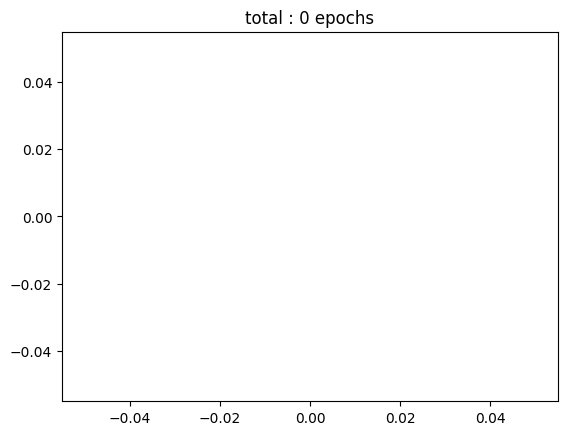

In [ ]:
plt.plot(range(len(Loss_hist)),Loss_hist)
plt.title('total : ' + str(len(Loss_hist)) + ' epochs' )

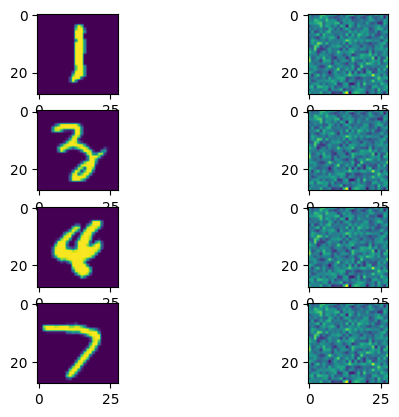

In [ ]:
for i in range(4):
    idx = random.randint(1,100)
    
    plt.subplot(4,2,1+2*i)
    plt.imshow(X_test[idx])
    plt.subplot(4,2,2+2*i)

    ae_model.eval()
    with torch.no_grad():
        img = (ae_model(X_test[idx].reshape((1,28,28)).to(torch.float32))).detach().numpy().reshape(28,28)
        plt.imshow(img)

In [ ]:
torch.save(ae_model.state_dict(), f'./ae_model/AutoEncoder_model_state_dict_latent=3_epoch={EPOCHs}_{time.time()}.pth')

# DCGANs

- inspired : [Github](https://github.com/Ksuryateja/DCGAN-MNIST-pytorch/blob/master/gan_mnist.py#L182C4-L182C4)

## Generator
- input : `(100,1,1)` random noise for 100 dimension
- output : `(1,28,28)` image of hand writing

## Discriminator
- input : `(1, 28, 28)`
- output : `True or False`

In [ ]:
class DCGAN_generator(nn.Module):
    def __init__(self, latent_dim = 100):
        super().__init__()

        self.model = nn.Sequential(
            nn.ConvTranspose2d(in_channels=100,
                               out_channels=1024,
                               kernel_size=4),
            nn.BatchNorm2d(1024),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=1024,
                               out_channels=512,
                               kernel_size=5),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=512,
                               out_channels=256,
                               kernel_size=9),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=256,
                               out_channels=1,
                               kernel_size=13),
            nn.Sigmoid(),
            
        )

    def forward(self, x_in):
        return self.model(x_in)

    def predict(self, x_pred):
        self.model.eval()
        return self.model(x_pred)

summary(DCGAN_generator(), (100,1,1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1           [-1, 1024, 4, 4]       1,639,424
       BatchNorm2d-2           [-1, 1024, 4, 4]           2,048
              ReLU-3           [-1, 1024, 4, 4]               0
   ConvTranspose2d-4            [-1, 512, 8, 8]      13,107,712
       BatchNorm2d-5            [-1, 512, 8, 8]           1,024
              ReLU-6            [-1, 512, 8, 8]               0
   ConvTranspose2d-7          [-1, 256, 16, 16]      10,617,088
       BatchNorm2d-8          [-1, 256, 16, 16]             512
              ReLU-9          [-1, 256, 16, 16]               0
  ConvTranspose2d-10            [-1, 1, 28, 28]          43,265
          Sigmoid-11            [-1, 1, 28, 28]               0
Total params: 25,411,073
Trainable params: 25,411,073
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Fo

In [ ]:
class DCGAN_discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
            nn.Conv2d(in_channels=1,
                      out_channels=32,
                      kernel_size=3,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.Conv2d(in_channels=32,
                      out_channels=64,
                      kernel_size=3,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout(p = 0.25),
            nn.Flatten(),
            nn.LeakyReLU(),
            nn.Linear(9216, 1),
            nn.Sigmoid()
        )

    def forward(self, x_in):
        return self.model(x_in) > 0.5

    def predict(self, x_pred):
        self.model.eval()
        return self.model(x_pred) > 0.5

summary(DCGAN_discriminator(), (1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 26, 26]             320
              ReLU-2           [-1, 32, 26, 26]               0
            Conv2d-3           [-1, 64, 24, 24]          18,496
              ReLU-4           [-1, 64, 24, 24]               0
         MaxPool2d-5           [-1, 64, 12, 12]               0
           Dropout-6           [-1, 64, 12, 12]               0
           Flatten-7                 [-1, 9216]               0
         LeakyReLU-8                 [-1, 9216]               0
            Linear-9                    [-1, 1]           9,217
          Sigmoid-10                    [-1, 1]               0
Total params: 28,033
Trainable params: 28,033
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 1.17
Params size (MB): 0.11
Estimated Tot

## Train DCGANs models

In [ ]:
DCGAN_model_D = DCGAN_discriminator()

DCGAN_model_G = DCGAN_generator()

In [ ]:
criterion = nn.BCELoss()

optimizer_D = torch.optim.Adam(DCGAN_model_D.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_G = torch.optim.Adam(DCGAN_model_G.parameters(), lr=0.0002, betas=(0.5, 0.999))


In [ ]:
EPOCHs = 1 if TRAIN_DCGAN else 0
BATCH_SIZE = 128

DCGAN_model_D.train()
DCGAN_model_G.train()

for epoch in range(EPOCHs):
    for i in range(X_train.shape[0]//BATCH_SIZE):
        # train generator model
        batch_x_train = X_train[BATCH_SIZE*i : BATCH_SIZE*i + BATCH_SIZE].reshape(-1,1,28,28)
        real_label = torch.ones((BATCH_SIZE, 1), dtype=torch.float32, requires_grad=True)
        fake_label = torch.zeros((BATCH_SIZE, 1), dtype=torch.float32, requires_grad=True)
        
        # -------------------------------
        # (1) train Discriminator model
        # -------------------------------
        DCGAN_model_G.eval()
        DCGAN_model_D.train()
        DCGAN_model_D.zero_grad()

        # -------------------------------------- !!!!! try combine and shuffle both dataset -> train together
        # (1.1) train with real image
        d_pred_real = DCGAN_model_D(batch_x_train).to(torch.float32)
        d_loss_real = criterion(d_pred_real, real_label)
        d_loss_real.backward()

        # (1.2) train with fake image
        noise = torch.randn(BATCH_SIZE, 100, 1, 1)
        fake_x = DCGAN_model_G(noise)
        d_pred_fake = DCGAN_model_D(fake_x).to(torch.float32)
        d_loss_fake = criterion(d_pred_fake, fake_label)
        d_loss_fake.backward()

        optimizer_D.step()

        d_loss = d_loss_real + d_loss_fake

        # -------------------------------
        # (2) train Generator model
        # -------------------------------
        DCGAN_model_G.train()
        DCGAN_model_D.eval()
        DCGAN_model_G.zero_grad()

        g_fake = DCGAN_model_G(noise)
        output = DCGAN_model_D(g_fake).to(torch.float32)
        g_loss = criterion(output, real_label)
        g_loss.backward()

        optimizer_G.step()
        
        # -------------------------------
        # test both model
        # -------------------------------
        DCGAN_model_D.eval()
        DCGAN_model_G.eval()

        with torch.inference_mode():
            pass
        
        print(f'Epoch : {epoch}/{EPOCHs}({i}/{X_train.shape[0]//BATCH_SIZE})', end = '\t|')
        print(f'D loss : {d_loss.item()}', end ='\t|')
        print(f'G loss : {g_loss.item()}', end = '\t|')
        print('')

Epoch : 0/1(0/468)	|D loss : 104.6875	|G loss : 100.0	|
Epoch : 0/1(1/468)	|D loss : 95.3125	|G loss : 100.0	|
Epoch : 0/1(2/468)	|D loss : 100.78125	|G loss : 100.0	|
Epoch : 0/1(3/468)	|D loss : 103.90625	|G loss : 100.0	|
Epoch : 0/1(4/468)	|D loss : 103.125	|G loss : 100.0	|
Epoch : 0/1(5/468)	|D loss : 111.71875	|G loss : 100.0	|
Epoch : 0/1(6/468)	|D loss : 103.90625	|G loss : 100.0	|
Epoch : 0/1(7/468)	|D loss : 103.90625	|G loss : 100.0	|
Epoch : 0/1(8/468)	|D loss : 103.90625	|G loss : 100.0	|
Epoch : 0/1(9/468)	|D loss : 102.34375	|G loss : 100.0	|
Epoch : 0/1(10/468)	|D loss : 99.21875	|G loss : 100.0	|
Epoch : 0/1(11/468)	|D loss : 106.25	|G loss : 100.0	|
Epoch : 0/1(12/468)	|D loss : 107.8125	|G loss : 100.0	|
Epoch : 0/1(13/468)	|D loss : 107.8125	|G loss : 100.0	|
Epoch : 0/1(14/468)	|D loss : 103.90625	|G loss : 100.0	|
Epoch : 0/1(15/468)	|D loss : 103.125	|G loss : 100.0	|
Epoch : 0/1(16/468)	|D loss : 104.6875	|G loss : 100.0	|
Epoch : 0/1(17/468)	|D loss : 102.3437

KeyboardInterrupt: 